In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'wine-dataset-for-clustering:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F626341%2F1116242%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240619%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240619T022435Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0b5452f15153aca2f1c5d1933936d2c7aa3ae39345b91b346babd775518c4f37c0a59afc495618e49310fcf019de34fc8e1bf20c37eeee1732091a62e6d4cff0fc42b1bfe4aa6ffff1cb1204107c3b7235bd91e8b6fc51dc4faa44b1b5c017599055118e2a38bd0e6d074933096a642ce0c6039090da065a26e2bc3b4c4eff2a6db04f68cb057bda6221eae349840720a5bbb076a188e1c02c10775fcfcc76a7227ad6d45cbe8701253b105dff9745ca1f3bc5dcef2e644de4bf735b48ab4151e2eefd2be1788941045290536216b2b8de196e7c8ebc829ed9f8fb0b4b5429683363685fae2de52c81caaee0885a0f48d2bb1520bcac9056517abaa91d997c54'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4461 bytes downloaded
Downloaded and uncompressed: wine-dataset-for-clustering
Data source import complete.


# Introduction

***Motivation***

This notebook utilizes a dataset containing the results of the chemical analysis of Italian wines to explore the **influence of dimensionality reduction on clustering results**. K-means is used (i) **without any** prior dimensionality reduction, (ii) with prior dimensionality reduction via principal component analysis (**PCA**), and (iii) with prior dimensionality reduction via **UMAP**. All other aspects are kept deliberately simple.


***Link to dataset***

https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering


***Data dictionary (from above source)***

Features (all numercial):
- Alcohol
- Malic acid
- Ash
- Alcalinity of ash
- Magnesium
- Total phenols
- Flavanoids
- Nonflavanoid phenols
- Proanthocyanins
- Color intensity
- Hue
- OD280/OD315 of diluted wines
- Proline


**Imports and global settings**

In [3]:
!pip install umap-learn
!pip install --upgrade umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.decomposition import PCA
import umap

from sklearn.cluster import KMeans

import random

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)

%config IPCompleter.use_jedi=False

**Reading in the dataset**

In [5]:
df = pd.read_csv("../input/wine-dataset-for-clustering/wine-clustering.csv")

df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


**Any duplicate rows?**

In [6]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [7]:
df.isnull().sum()

Alcohol                 0
Malic_Acid              0
Ash                     0
Ash_Alcanity            0
Magnesium               0
Total_Phenols           0
Flavanoids              0
Nonflavanoid_Phenols    0
Proanthocyanins         0
Color_Intensity         0
Hue                     0
OD280                   0
Proline                 0
dtype: int64

**Checking data types**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


**Cleaning up column names (mainly for handling purposes)**

In [9]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


**Quick overview over the individual distributions**

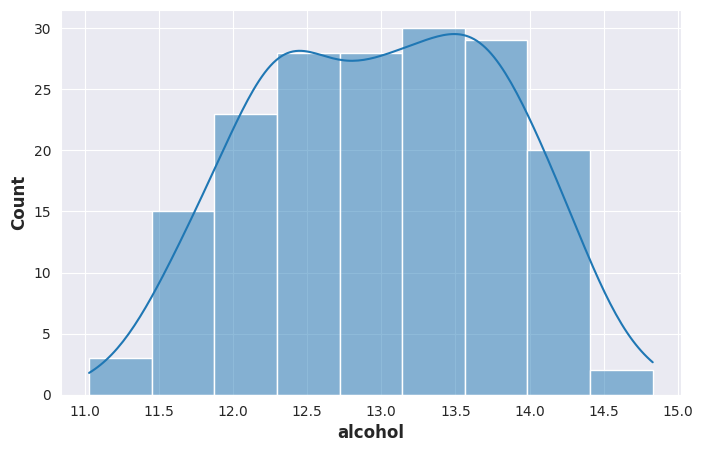

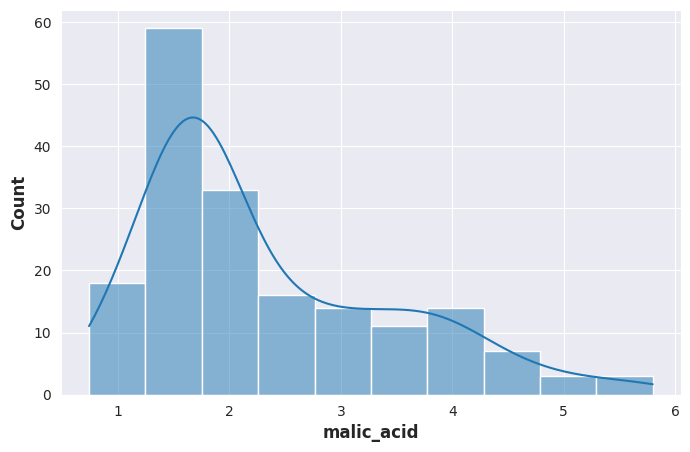

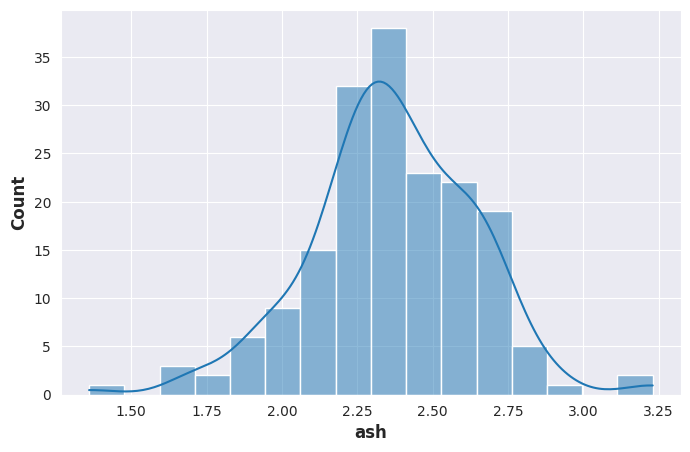

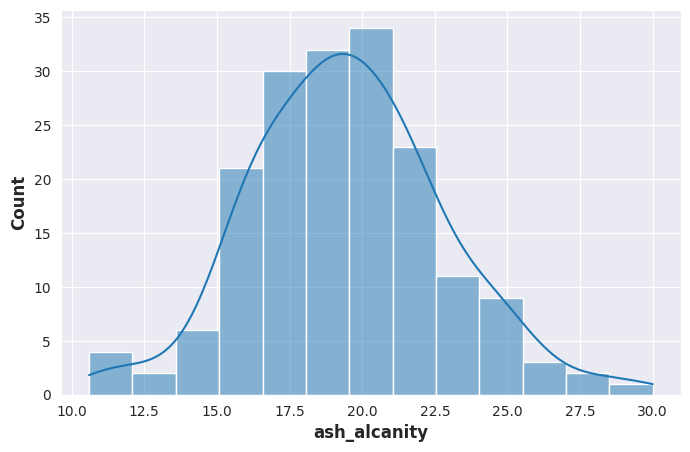

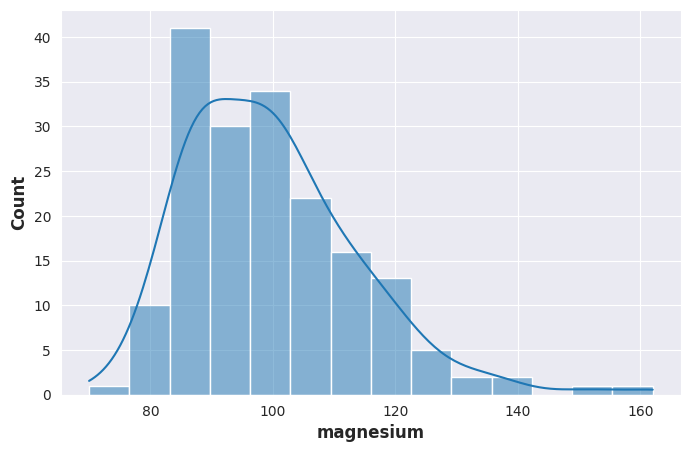

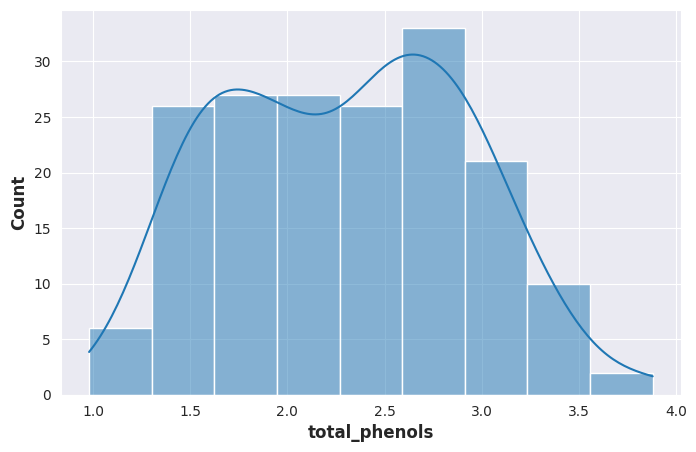

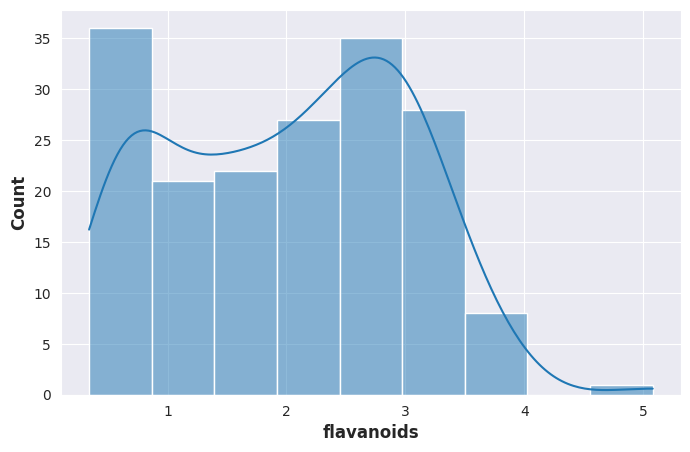

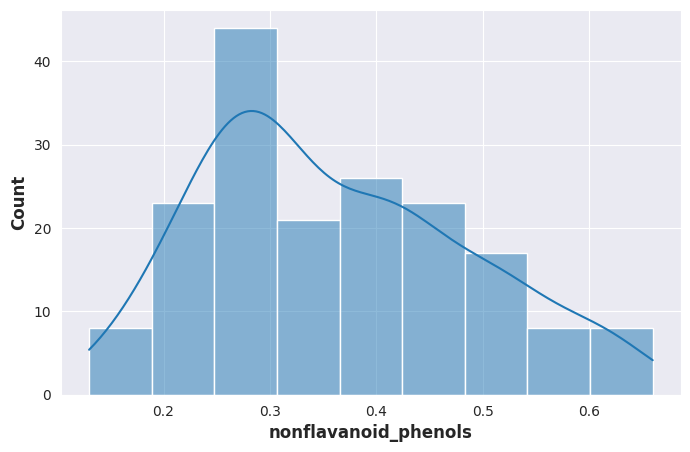

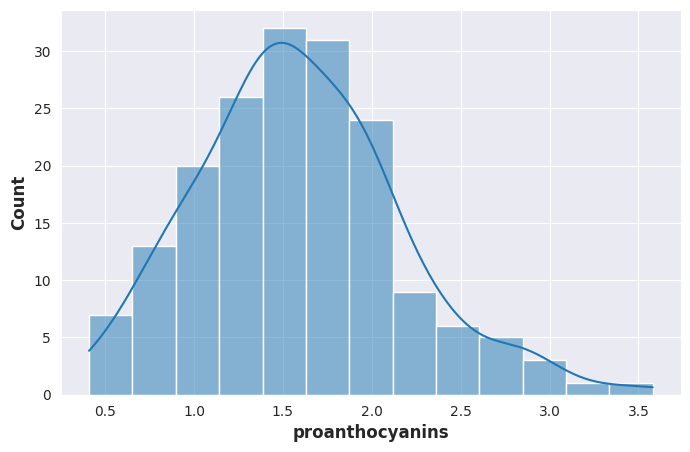

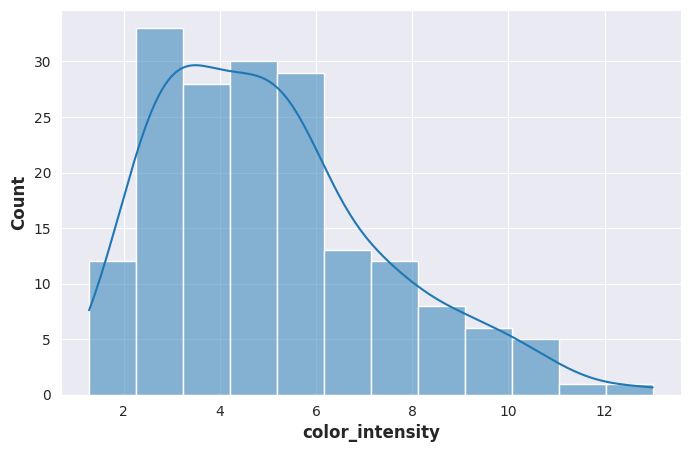

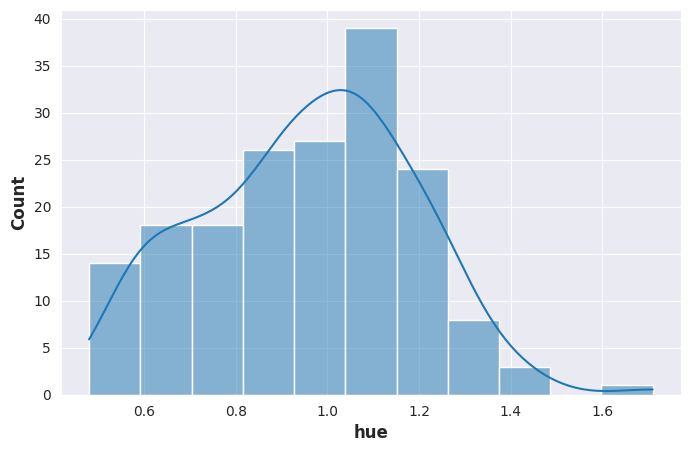

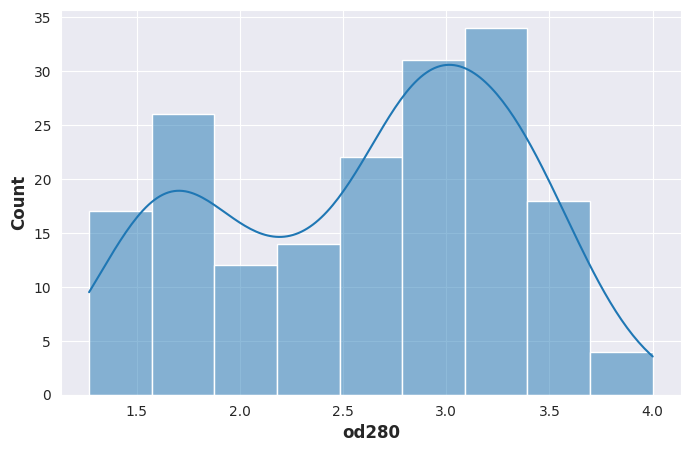

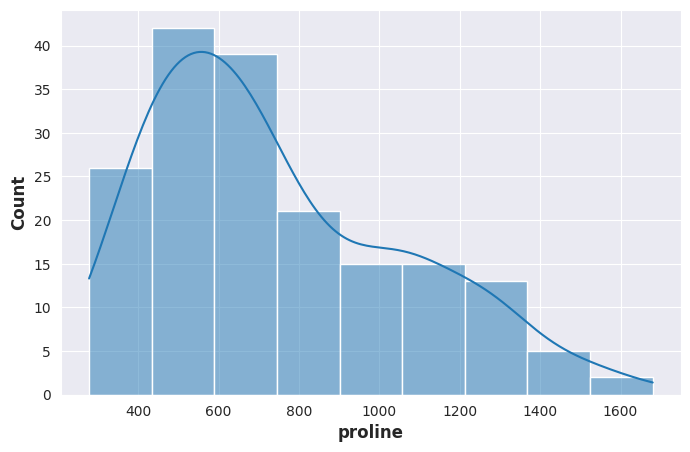

In [12]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

===> distributions require scaling and standardization

In [13]:
X = df.copy()

# Clustering

## Scaling and Standardizing

In [14]:
X = StandardScaler().fit_transform(df)

In [15]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [16]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

,alcohol,malic_acid,ash,ash_alcanity,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1.552972,-0.702436,0.233769,-1.224710,1.378174,0.796708,1.043661,-0.729831,1.093141,0.235133,0.363665,2.262034,0.793386
1,0.247472,-0.610198,-0.809540,-2.696922,0.018056,0.562211,0.738364,-0.926936,-0.578400,-0.317844,0.407900,1.278188,0.762788
2,0.197645,0.021031,1.141607,-0.272253,0.086325,0.796708,1.227314,-0.539574,1.802679,0.250223,0.319467,0.875251,1.022728
3,1.732995,-0.400457,0.495037,-0.837478,0.767296,2.405004,1.482916,-1.130495,0.934182,0.921471,-0.425517,1.368576,1.500126
4,0.297382,0.207225,1.919073,0.442690,1.001563,0.796708,0.667285,0.218295,0.383679,-0.348242,0.363665,0.479405,-0.038337


## Attempt 1: K-means without any prior dimensionality reduction

**Identifying the "optimal" number of clusters**

In [17]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

# inertias_1

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

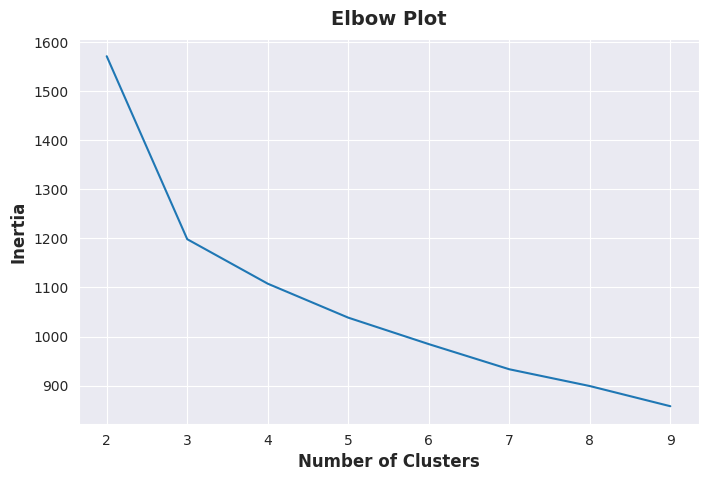

In [18]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
# plt.ylim(bottom=0)
plt.show()

===> "kink" at 3 clusters

**Clustering**

In [19]:
labels_1 = KMeans(n_clusters=3, random_state=fixed_random_state).fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Reduction to 2 dimensions *after* clustering so to be able to plot the results

In [20]:
reducer_1 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_1 = reducer_1.fit_transform(X)

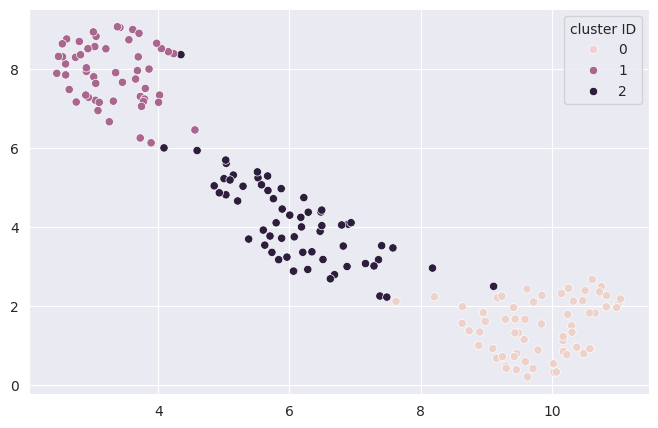

In [21]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_1[:, 0], y=embedding_1[:, 1], hue=labels_1)
plt.legend(title="cluster ID")
plt.show()

===> Results seem reasonable. Minor "overlaps".

## Attempt 2: K-means with prior dimensionality reduction via PCA

**Identifying the "optimal" number of (principal) components to keep**

In [22]:
pca_2 = PCA(n_components=10, random_state=fixed_random_state).fit(X)

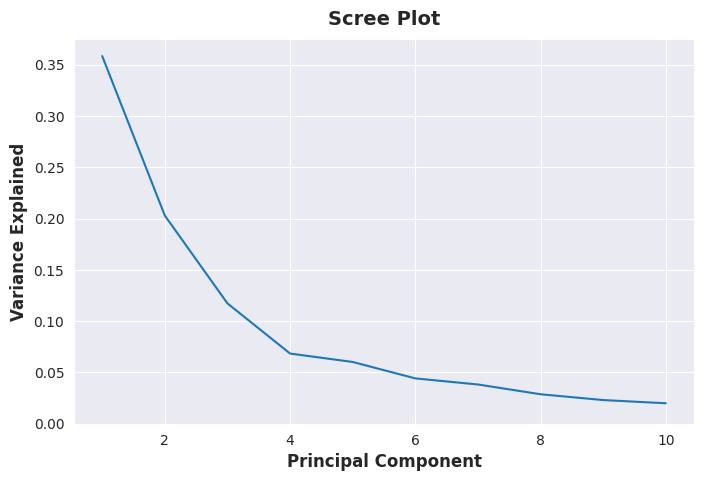

In [23]:
princ_comps_2 = np.arange(pca_2.n_components_, dtype=int) + 1

fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=princ_comps_2, y=pca_2.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(bottom=0)
plt.show()

===> "kink" at 4 components

**Reduction to 4 dimensions**

In [24]:
X_red_2 = PCA(n_components=4, random_state=fixed_random_state).fit_transform(X)

In [25]:
X_red_2 = pd.DataFrame(X_red_2, columns=["pc1", "pc2", "pc3", "pc4"])

X_red_2.head()

,pc1,pc2,pc3,pc4
0,-3.361355,-1.335128,-0.241050,0.034622
1,-2.232559,0.183505,-2.117771,-0.314983
2,-2.361378,-1.061396,1.076760,0.495528
3,-3.661182,-2.383114,-0.072985,0.715901
4,-0.977118,-1.100360,2.028880,-0.459807


**Identifying the "optimal" number of clusters**

In [26]:
inertias_2 = []
range_clusters_2 = np.arange(2, 10, dtype=int)

for n in range_clusters_2:
    kmeans_2 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X_red_2)
    inertias_2.append(kmeans_2.inertia_)

# inertias_2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

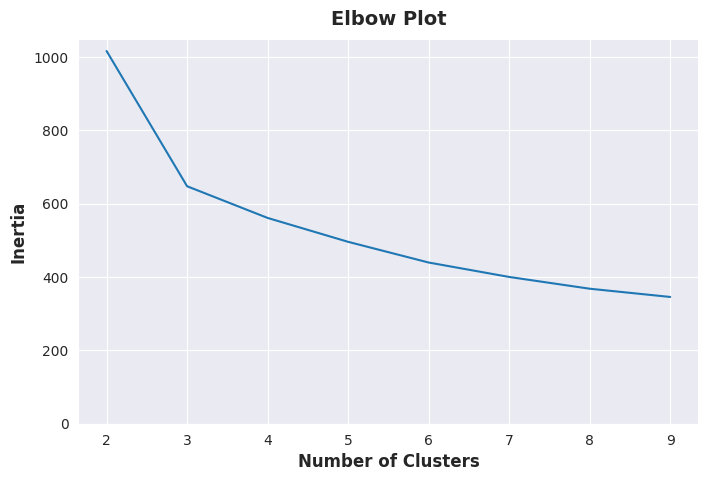

In [27]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_2, y=inertias_2)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

===> "kink" at 3 clusters

**Clustering on dataset with reduced dimensions**

In [28]:
labels_2 = KMeans(n_clusters=3, random_state=fixed_random_state).fit_predict(X_red_2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Reduction to 2 dimensions *after* clustering so to be able to plot the results

In [29]:
reducer_2 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_2 = reducer_2.fit_transform(X_red_2)

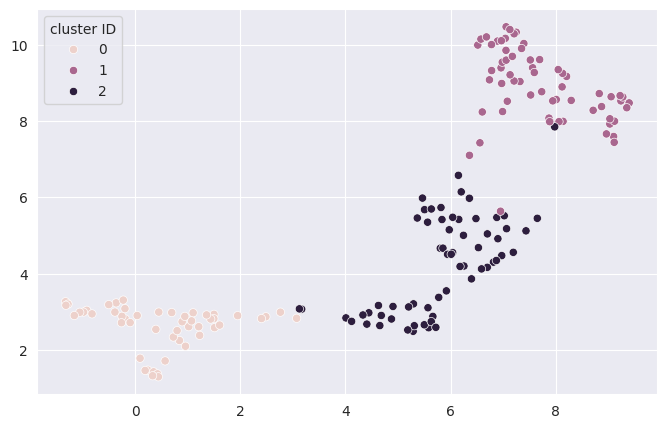

In [30]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_2[:, 0], y=embedding_2[:, 1], hue=labels_2)
plt.legend(title="cluster ID")
plt.show()

===> Results seem reasonable. Minor "overlaps".

## Attempt 3: K-means with prior dimensionality reduction via UMAP

**Reduction to 2 dimensions**

In [31]:
reducer_3 = umap.UMAP(n_components=2, n_neighbors=15, n_jobs=-1, random_state=fixed_random_state)
embedding_3 = reducer_3.fit_transform(X)

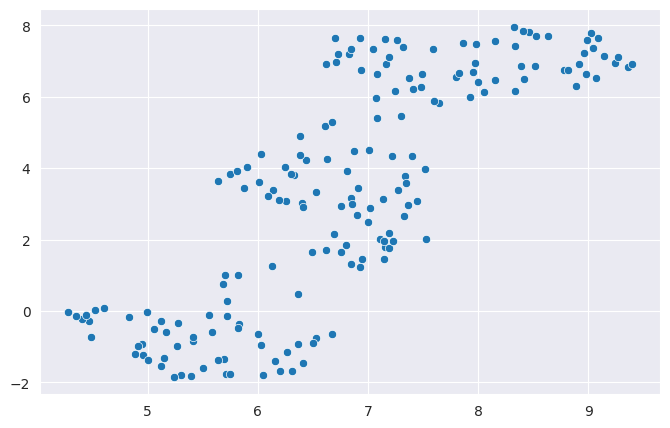

In [32]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_3[:, 0], y=embedding_3[:, 1])
plt.show()

In [33]:
X_red_3 = pd.DataFrame(embedding_3, columns=["comp_1", "comp_2"])

# sanity check
X_red_3.head()

,comp_1,comp_2
0,9.240086,6.959729
1,8.337206,6.155940
2,7.593139,7.330292
3,9.085086,7.639377
4,6.707445,6.989373


**Identifying the "optimal" number of clusters**

In [34]:
inertias_3 = []
range_clusters_3 = np.arange(2, 10, dtype=int)

for n in range_clusters_3:
    kmeans_3 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X_red_3)
    inertias_3.append(kmeans_3.inertia_)

# inertias_3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

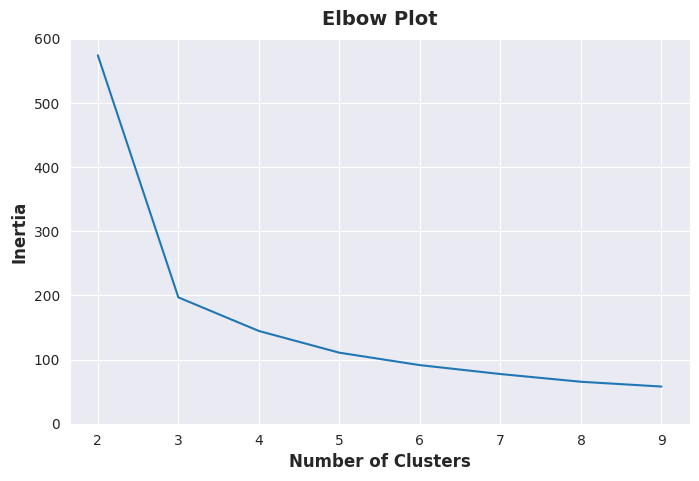

In [35]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_3, y=inertias_3)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

==> "kink" at 3 clusters

**Clustering on dataset with reduced dimensions**

In [36]:
labels_3 = KMeans(n_clusters=3, random_state=fixed_random_state).fit_predict(X_red_3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


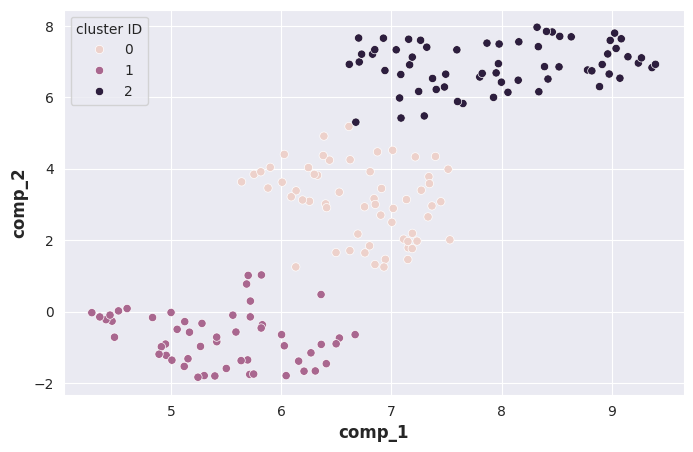

In [37]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data=X_red_3, x="comp_1", y="comp_2", hue=labels_3)
plt.legend(title="cluster ID")
plt.show()

===> Results seem reasonable. No "overlaps" as with the other approaches.

## Comparision of the different approaches

**Re-plotting the identified clusters by each approach side-by-side for convenience**

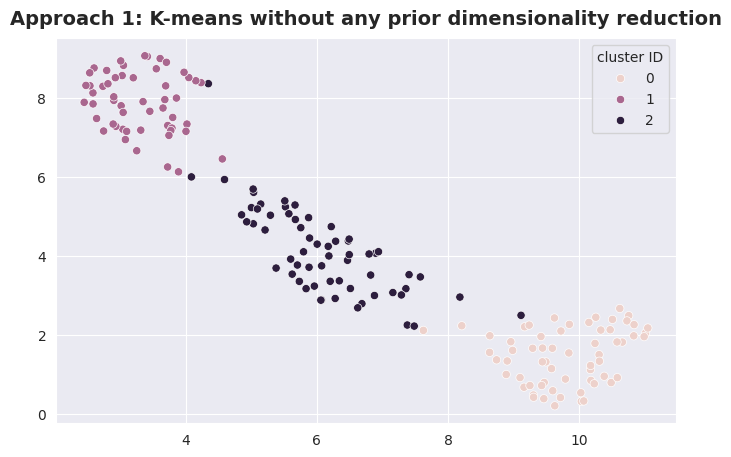

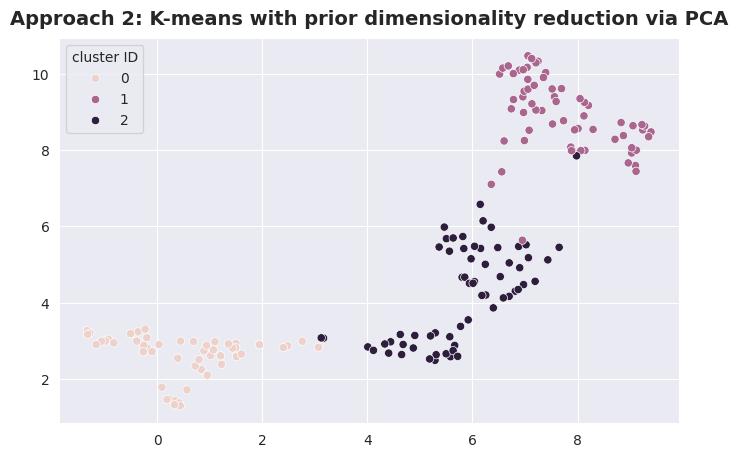

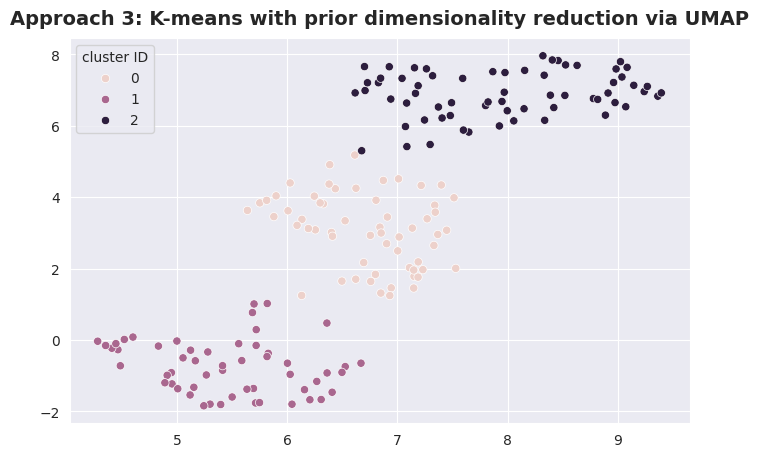

In [38]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_1[:, 0], y=embedding_1[:, 1], hue=labels_1)
plt.title("Approach 1: K-means without any prior dimensionality reduction")
plt.legend(title="cluster ID")
plt.show()

plt.figure(figsize=std_figure_size)
sns.scatterplot(x=embedding_2[:, 0], y=embedding_2[:, 1], hue=labels_2)
plt.title("Approach 2: K-means with prior dimensionality reduction via PCA")
plt.legend(title="cluster ID")
plt.show()

plt.figure(figsize=std_figure_size)
sns.scatterplot(data=X_red_3, x="comp_1", y="comp_2", hue=labels_3)
plt.title("Approach 3: K-means with prior dimensionality reduction via UMAP")
plt.xlabel(None)
plt.ylabel(None)
plt.legend(title="cluster ID")
plt.show()

===> All three approaches generate reasonable results, with the last one being slightly superior as it does not feature any overlaps at all.

**Comparing the elbow plots for each "optimal number of clusters" search side-by-side**

As a reminder, k-means' inertia metric is *not* normalized.

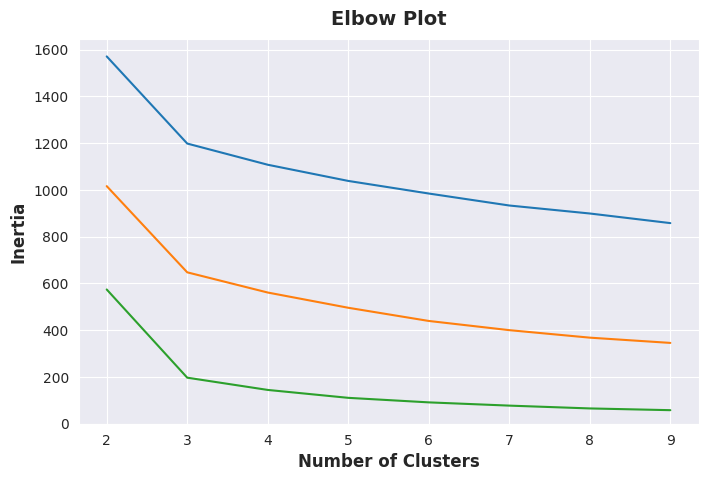

In [48]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
sns.lineplot(x=range_clusters_2, y=inertias_2)
sns.lineplot(x=range_clusters_3, y=inertias_3)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.ylim(bottom=0)
plt.show()

===> All 3 lines lead to the same conclusions.

**Swapping cluster IDs so to make the results for the 3 approaches directly comparable**

Taking the label IDs as generated by "approach 1" as reference.

In [40]:
def corr_labels_2(elem):
    if elem == 1:
        return 2
    elif elem == 2:
        return 1
    else:
        return elem


labels_2 = pd.Series(labels_2).apply(corr_labels_2)

In [41]:
def corr_labels_3(elem):
    if elem == 1:
        return 0
    elif elem == 0:
        return 1
    else:
        return elem


labels_3 = pd.Series(labels_3).apply(corr_labels_3)

**Side-by-side comparison of the feature distributions for each cluster across all 3 approaches**

N.B.: Please keep in mind that each approach can "order" the cluster IDs differently, meaning that ID 0 for approach 1 might be the same as ID 2 for approach 2 and ID 1 for approach 3. As there is a quite a bit of randomness to this, I had to give up on "manually rearranging" the results so to make it easier to directly cross-compare.

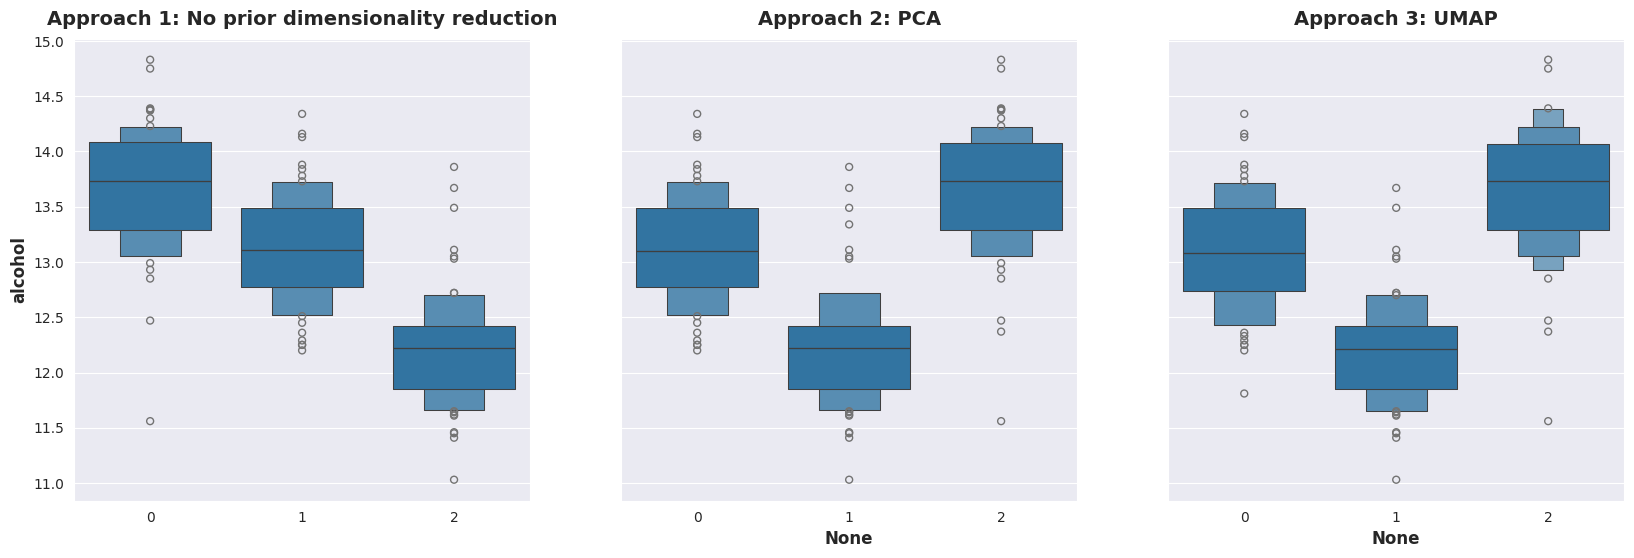

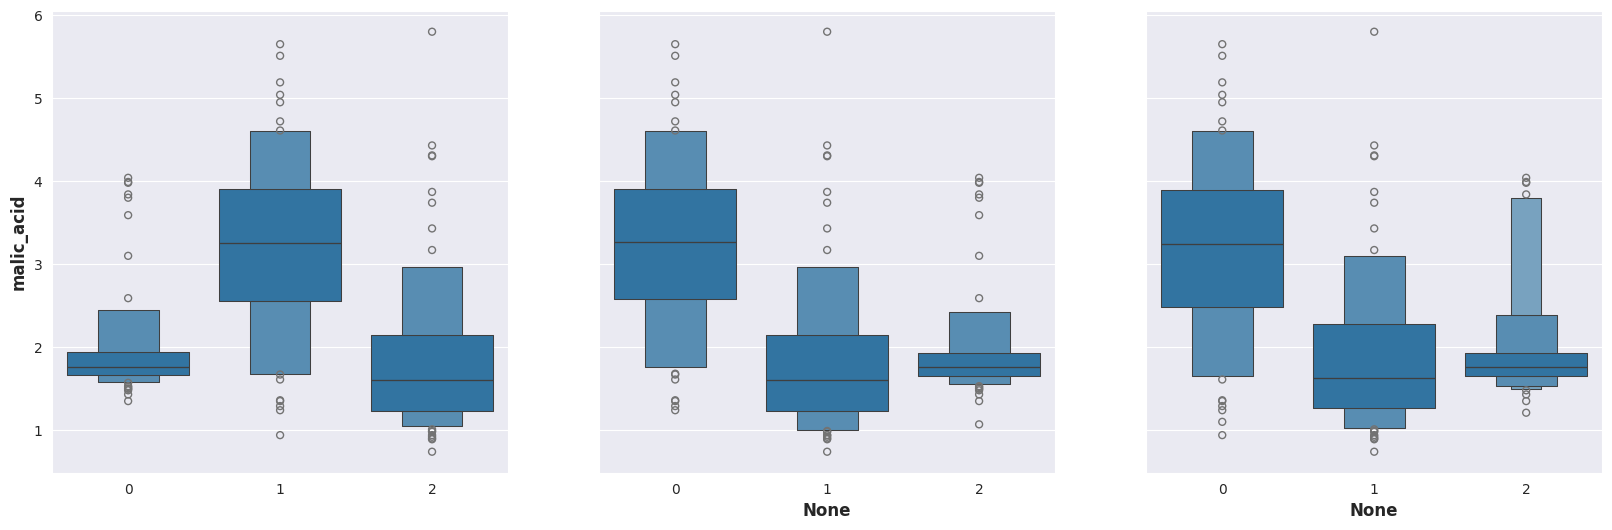

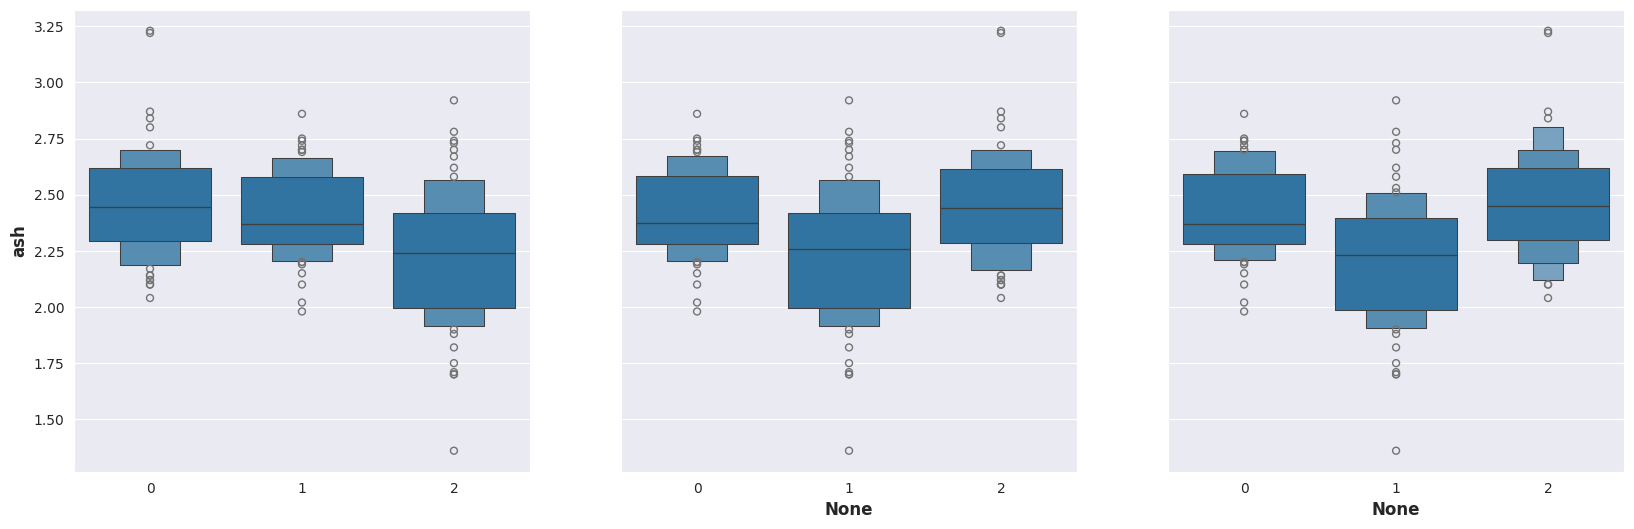

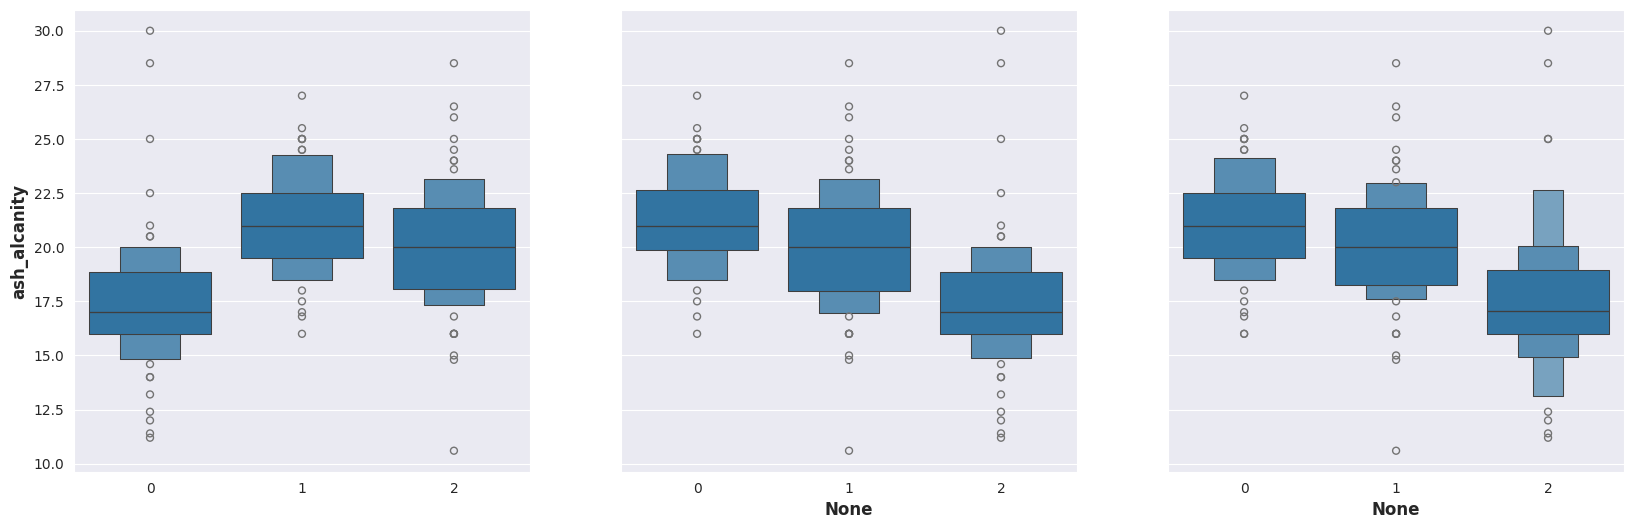

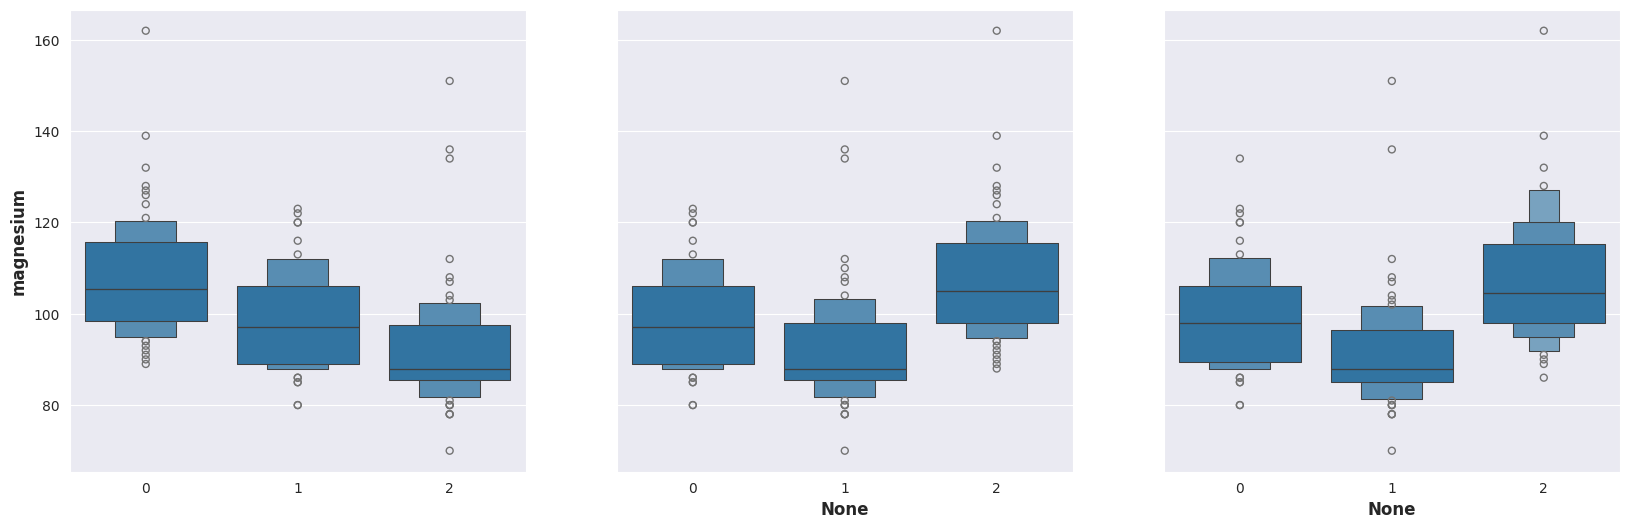

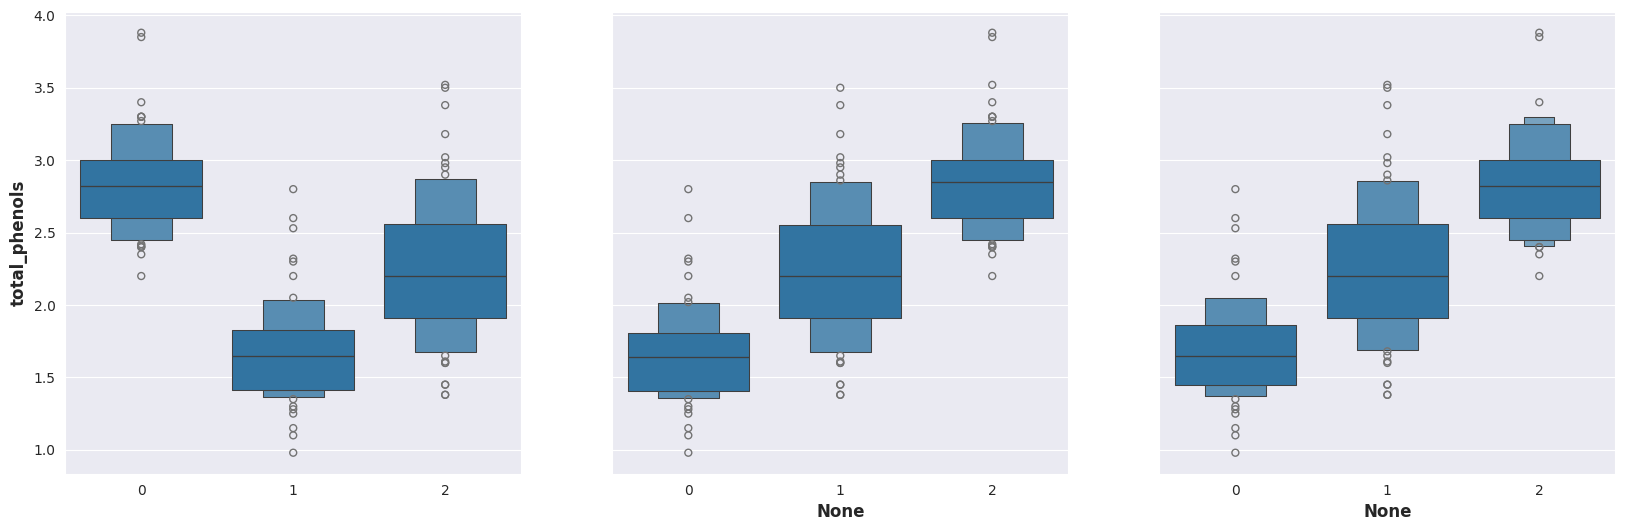

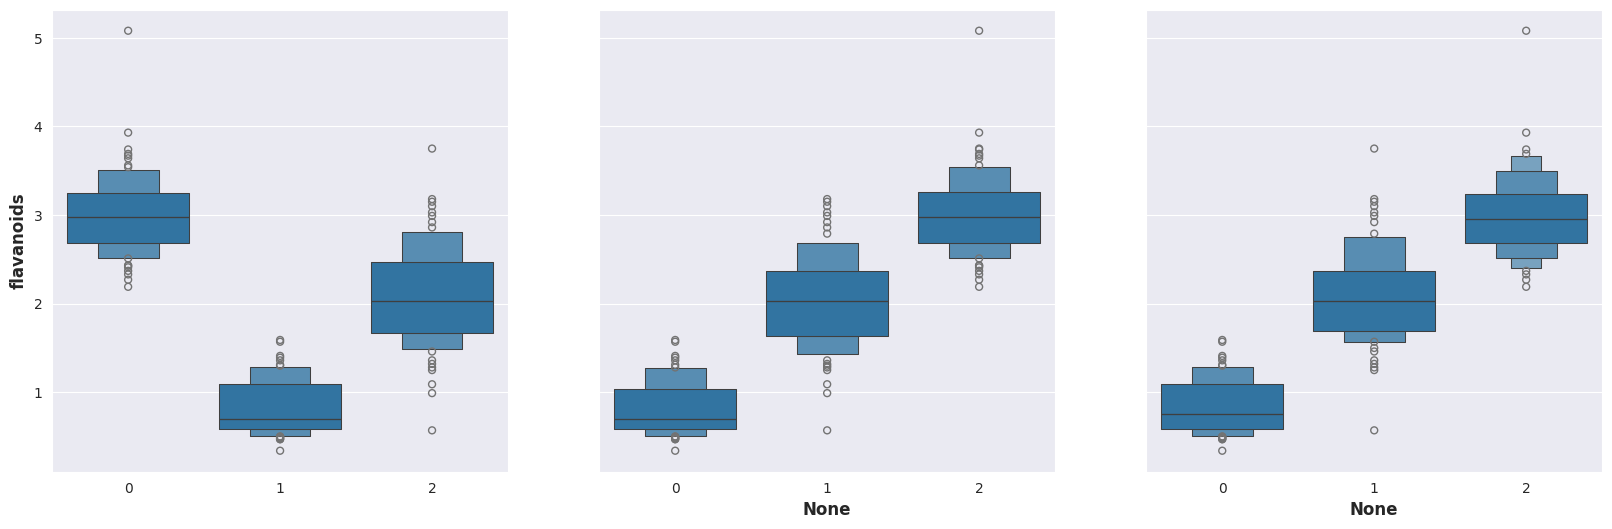

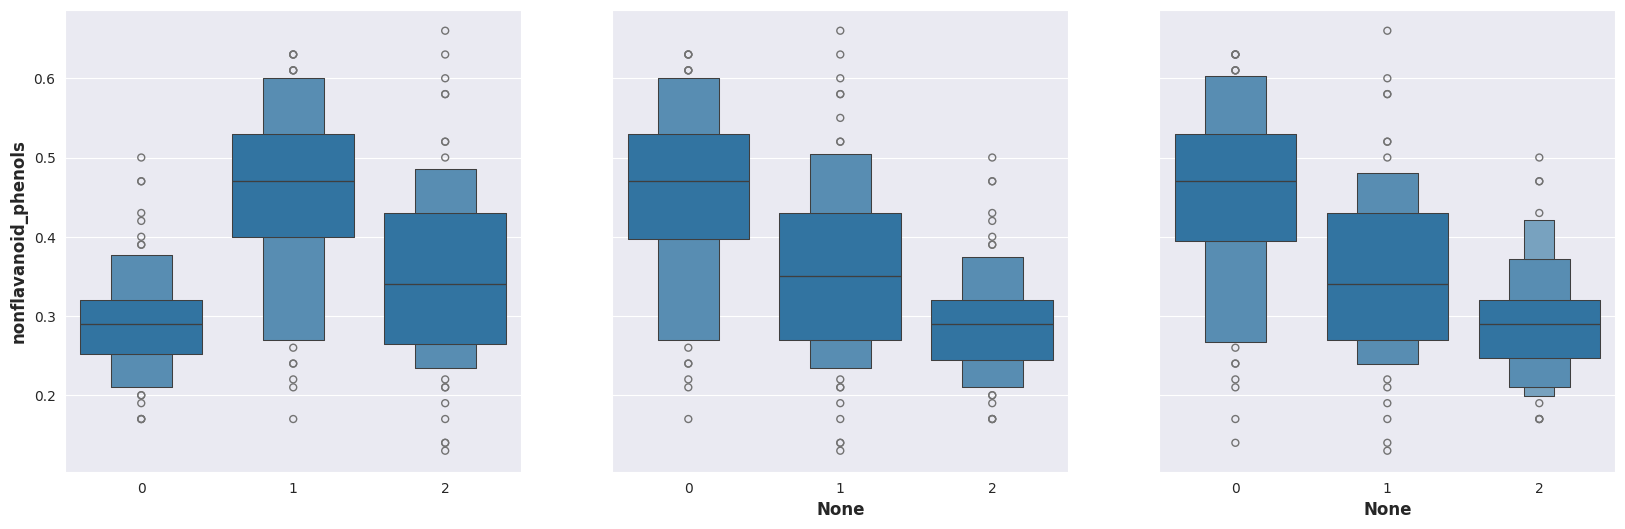

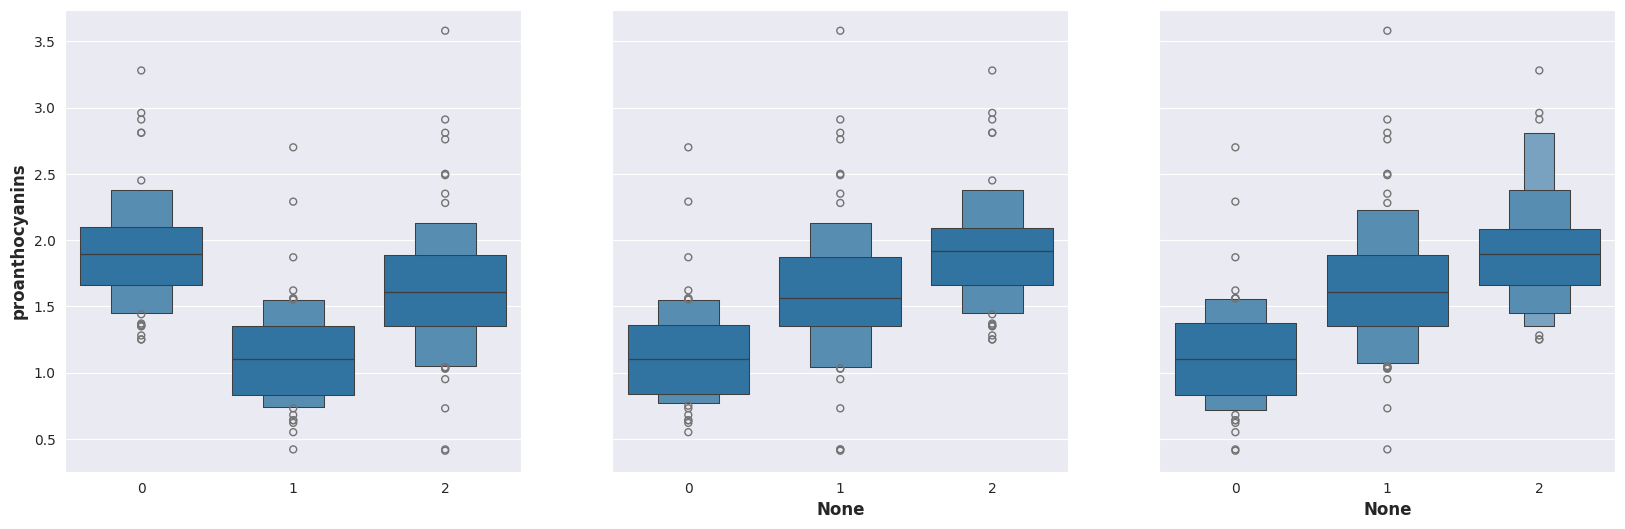

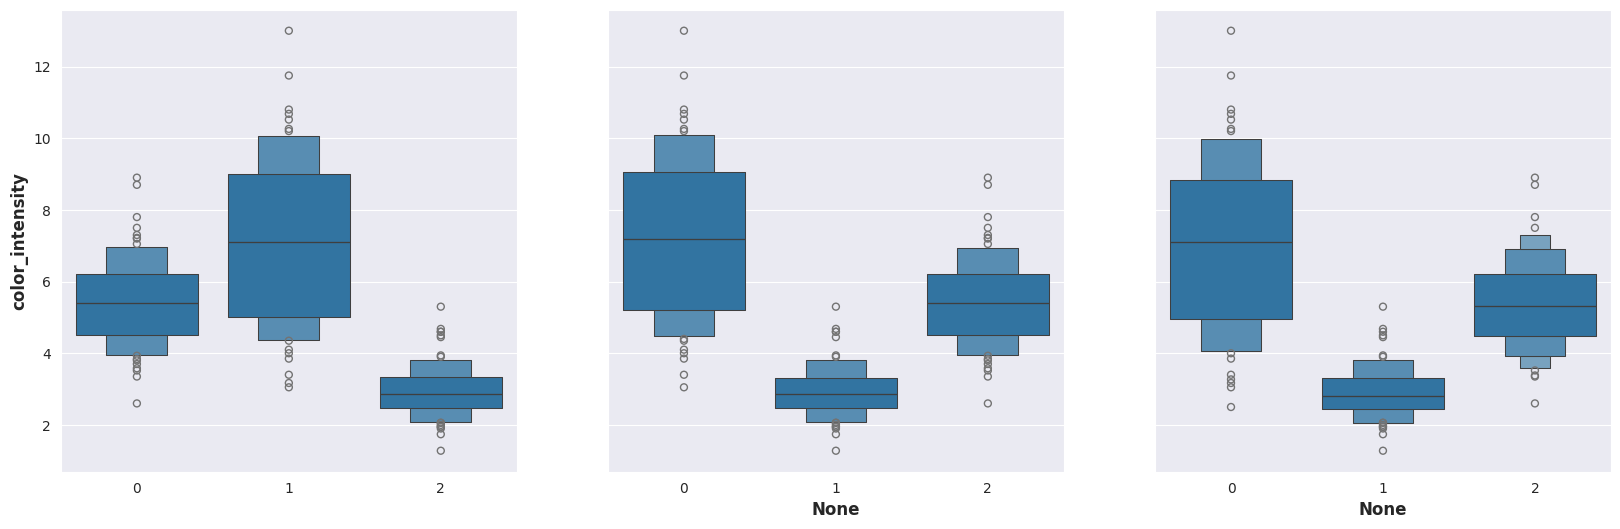

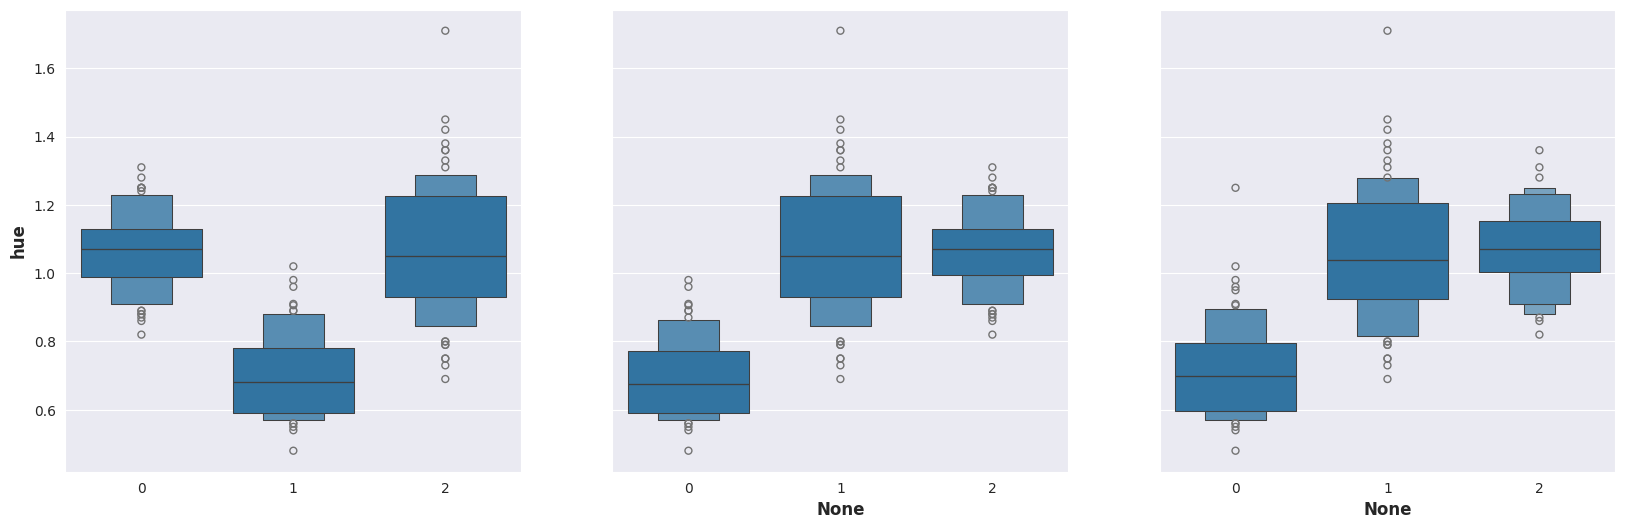

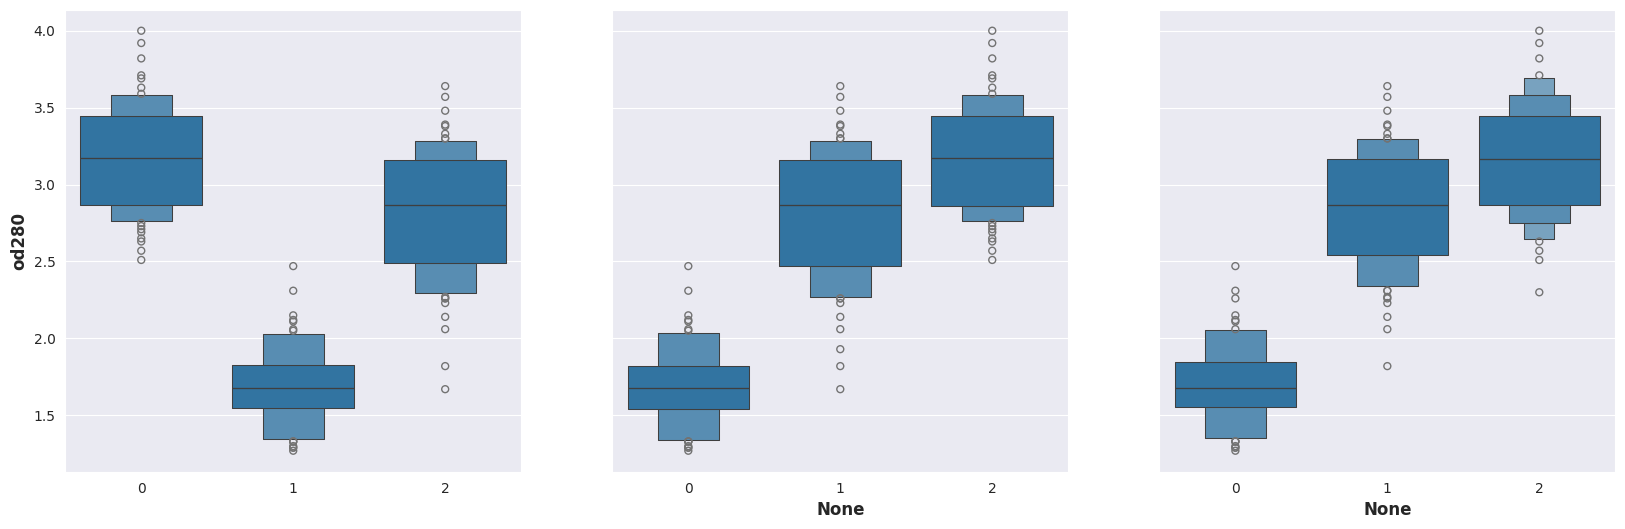

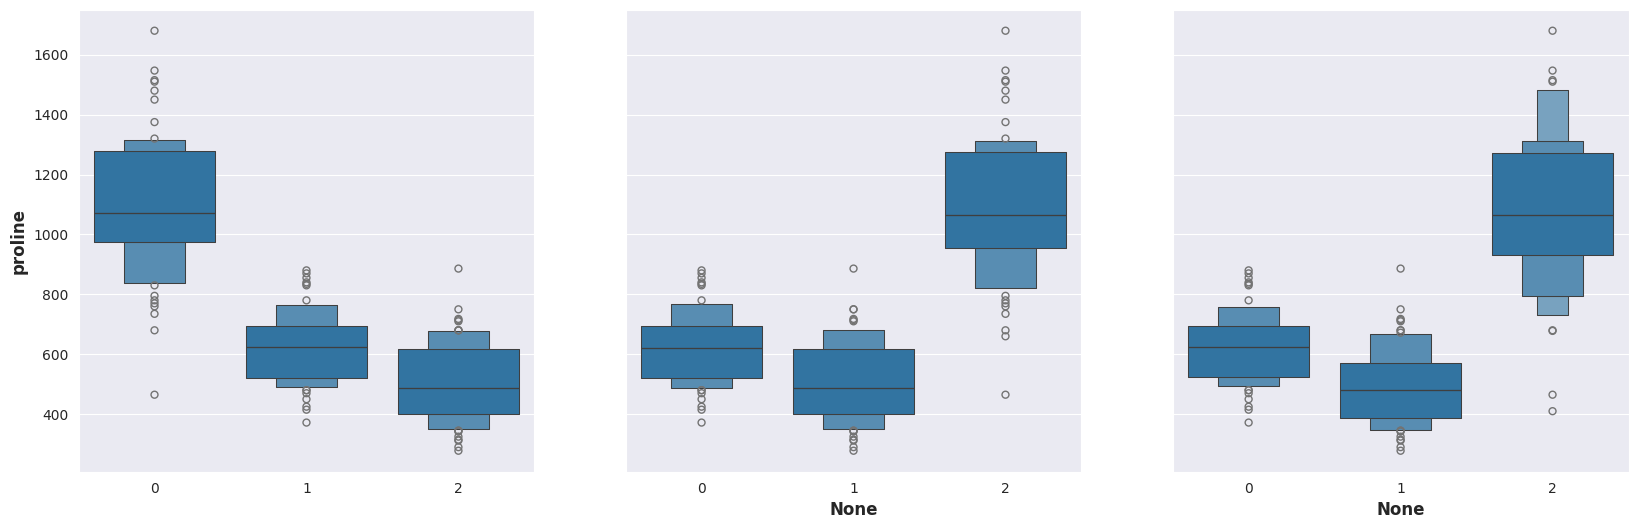

In [42]:
for i, col in enumerate(df.columns):
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,6))
    sns.boxenplot(x=labels_1, y=df[col], ax=axs[0])
    sns.boxenplot(x=labels_2, y=df[col], ax=axs[1])
    sns.boxenplot(x=labels_3, y=df[col], ax=axs[2])
    if i == 0:
        axs[0].set_title("Approach 1: No prior dimensionality reduction")
        axs[1].set_title("Approach 2: PCA")
        axs[2].set_title("Approach 3: UMAP")
    plt.show()

===> Surprisingly enough, the results are *almost* identical!

**How many data points are there in each cluster for each approach?**

In [43]:
counts_1 = pd.Series(labels_1).value_counts().sort_index()
counts_2 = pd.Series(labels_2).value_counts().sort_index()
counts_3 = pd.Series(labels_3).value_counts().sort_index()

cluster_counts = pd.DataFrame({"app_1": counts_1, "app_2": counts_2, "app_3": counts_3})

cluster_counts.index.name = "cluster_id"

cluster_counts

,app_1,app_2,app_3
cluster_id,,,
0,62,52,55
1,53,63,59
2,63,63,64


===> Very similar but not identical.

# Conclusion

The results proved to be **surprisingly similar**, even more so considering that all major components of this analysis (PCA, UMAP, and K-means) have a stochastic component. This, in turn, might even explain the extent of observed differences in the above plot.
As a general caveat though, the dataset used here is very small in both, number of features and number of observations.

**Please let me know in the comments in case you have a hypothesis as to why those 3 approaches generate results that are seemingly identical. Many thanks!**